In [102]:
# !pip install pyarrow

In [103]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

#import xgbtune 

In [104]:
df = pd.read_parquet("../data/dataset.parquet")
df

,date,open,high,low,close,adj close,volume,up_down_close_1,volitility_open_7,volitility_pct_change_7_open,...,volume_lag_29,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
0,2004-09-07,0.632143,0.646250,0.629107,0.638571,0.539257,301957600,1,NaN,NaN,...,NaN,1,7,9,2004,37,0.638571,0.638571,0.000000,0.000000
1,2004-09-08,0.637500,0.653036,0.637143,0.649107,0.548155,343526400,0,NaN,NaN,...,NaN,2,8,9,2004,37,0.638984,0.638676,0.000308,0.000247
2,2004-09-09,0.644643,0.648214,0.630000,0.637500,0.538353,461339200,1,NaN,NaN,...,NaN,3,9,9,2004,37,0.638926,0.638664,0.000262,0.000160
3,2004-09-10,0.636786,0.646964,0.633214,0.640536,0.540917,328014400,0,NaN,NaN,...,NaN,4,10,9,2004,37,0.638989,0.638683,0.000306,0.000164
4,2004-09-13,0.640714,0.644107,0.630714,0.635536,0.536694,281976800,0,NaN,NaN,...,NaN,0,13,9,2004,38,0.638854,0.638651,0.000202,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2024-08-28,227.919998,229.860001,225.679993,226.490005,226.490005,38052200,1,0.923404,0.006101,...,66034600.0,2,28,8,2024,35,217.620510,197.257194,20.363317,0.377713
5029,2024-08-29,230.100006,232.919998,228.880005,229.789993,229.789993,51906300,0,1.512537,0.006784,...,49151500.0,3,29,8,2024,35,218.097745,197.580903,20.516842,0.424990
5030,2024-08-30,230.190002,230.399994,227.479996,229.000000,229.000000,52990800,0,1.821776,0.006832,...,48201800.0,4,30,8,2024,35,218.525284,197.893531,20.631753,0.431922
5031,2024-09-03,228.550003,229.000000,221.169998,222.770004,222.770004,50042900,0,1.845363,0.007475,...,39960300.0,1,3,9,2024,36,218.691744,198.141058,20.550686,0.280683


In [105]:
# target = "target_close"
# target = "close_percent_change_1"
target = "up_down_close_1"

x = df.drop(columns=[target]).set_index("date")
y = df[["date", target]].set_index("date")
y

,up_down_close_1
date,
2004-09-07,1
2004-09-08,0
2004-09-09,1
2004-09-10,0
2004-09-13,0
...,...
2024-08-28,1
2024-08-29,0
2024-08-30,0


In [106]:
table_info = pd.DataFrame()

# Print columns that are not int, float, bool or category
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        table_info = pd.concat([table_info, pd.DataFrame({"Column Name": [col], "Data Type": [x[col].dtype]})])

table_info

,Column Name,Data Type
0,volume,int64
0,on_balance_volume_1,int64
0,crossed_close_bollinger_lower_30_close_event_name,object
0,crossed_close_close_bollinger_upper_30_event_name,object
0,dividends_event_name,object
0,splits_event_name,object


In [107]:
# Convert columns to float if they are not int, float, bool or category. Handle Cannot cast DatetimeArray to dtype float64 (XGBoosted models cannot use strings, but categories as enumerated values)
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        try:
            x[col] = x[col].astype("float")
        except:
            # drop datetime columns
            x = x.drop(columns=[col])

            print(f"Dropped Column: {col}")

Dropped Column: crossed_close_bollinger_lower_30_close_event_name
Dropped Column: crossed_close_close_bollinger_upper_30_event_name
Dropped Column: dividends_event_name
Dropped Column: splits_event_name


In [108]:
# # Normalizing the features between 0 and 1
# y_scaler = MinMaxScaler()
# y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# x_scaler = MinMaxScaler()
# x = x_scaler.fit_transform(x)

# y

In [109]:
#    All Features   | Target
# +-----------------+---------+
# | x_train         | y_train | <- 85% of the data which is used for training
# |                 |         |
# +-----------------+---------+
# | x_test          | y_test  | <- 15% of the data which is used for testing
# +-----------------+---------+


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
# x_train

In [110]:
# y_test

In [111]:
x_train

,open,high,low,close,adj close,volume,volitility_open_7,volitility_pct_change_7_open,high_low_7,high_close_7,...,volume_lag_29,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
date,,,,,,,,,,,,,,,,,,,,,
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.214233,9.464000e+07,0.336430,0.006379,0.579998,0.584999,...,102355600.0,4,5,1,2018,1,42.471561,38.973746,3.497815,-0.037491
2015-07-01,31.725000,31.735001,31.497499,31.650000,28.453873,1.209552e+08,0.299414,0.010551,0.237501,0.377501,...,145819600.0,2,1,7,2015,27,31.875641,29.514058,2.361583,-0.134248
2014-05-16,21.022499,21.340357,20.907143,21.339643,18.853840,2.762564e+08,0.124144,0.007795,0.433214,0.311071,...,275251200.0,4,16,5,2014,20,20.000955,18.887957,1.112998,0.123029
2023-09-21,174.550003,176.300003,173.860001,173.929993,173.044495,6.304790e+07,1.762638,0.015258,2.440002,0.809998,...,54686900.0,3,21,9,2023,38,180.917889,171.044192,9.873696,-1.034344
2012-07-18,21.663929,21.726429,21.555714,21.652143,18.284702,2.527000e+08,0.206811,0.013338,0.170715,0.049999,...,401455600.0,2,18,7,2012,29,20.876451,18.383837,2.492614,0.000360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-05,5.189643,5.228571,5.114643,5.166786,4.363222,6.327160e+08,0.138942,0.011560,0.113928,0.095000,...,540764000.0,4,5,6,2009,23,4.435661,4.204187,0.231474,0.067922
2009-04-23,4.522143,4.542857,4.411071,4.478571,3.782042,9.451568e+08,0.110028,0.022638,0.131786,0.203214,...,768457200.0,3,23,4,2009,17,3.833642,4.048125,-0.214482,0.083532
2005-11-01,2.044286,2.076429,2.031071,2.053571,1.734190,7.496860e+08,0.027971,0.023228,0.045358,0.019643,...,434747600.0,1,1,11,2005,44,1.848818,1.527969,0.320849,0.009797


In [112]:
import numpy

from itertools import count, takewhile
def frange(start, stop, step):
    return takewhile(lambda x: x< stop, count(start, step))

# list(frange(0, 1, 0.1))
numpy.linspace(5, 10, num=6).tolist()

[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [113]:
y_train

,up_down_close_1
date,
2018-01-05,0
2015-07-01,0
2014-05-16,1
2023-09-21,1
2012-07-18,1
...,...
2009-06-05,0
2009-04-23,0
2005-11-01,1


In [114]:
from xgboost import XGBClassifier

# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=150, max_depth=7, eta=0.05, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.05, subsample=1, colsampvle_bytree=.3)
model = XGBClassifier(n_estimators=500, max_depth=5, eta=0.05, subsample=0.9, colsample_bytree=0.4)
model.fit(x_train, y_train)



pickle.dump(model, open("../model/xgboost_model.pkl", "wb")) # Save model as Python pickle object
model.save_model("../model/xgboost_model.json")

In [115]:
# print(model.best_params_)
# model


In [116]:
predicted = model.predict(x_test)
y_test["predicted"] = predicted
y_test

,up_down_close_1,predicted
date,,
2013-11-26,1,0
2019-11-29,0,0
2008-02-14,0,0
2022-12-23,0,0
2023-12-13,1,0
...,...,...
2013-02-08,1,1
2014-10-20,1,1
2009-09-25,1,1


In [125]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test[target], y_test["predicted"])
print("accuracy:", accuracy)

balanced_accuracy_score = metrics.balanced_accuracy_score(y_test[target], y_test["predicted"])
print("balanced_accuracy_score:", balanced_accuracy_score)

recall = metrics.recall_score(y_test[target], y_test["predicted"])
print("recall:", recall)

precision = metrics.precision_score(y_test[target], y_test["predicted"])
print("precision:", precision)

average_precision = metrics.average_precision_score(y_test[target], y_test["predicted"])
print("average_precision:", average_precision)

f1 = metrics.f1_score(y_test[target], y_test["predicted"])
print("f1:", f1)

# more metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


accuracy: 0.5153922542204568
balanced_accuracy_score: 0.5098885207345076
recall: 0.575091575091575
precision: 0.5508771929824562
average_precision: 0.5471921215714662
f1: 0.5627240143369175
top_k_accuracy: 1.0


c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


accuracy: 0.5153922542204568
recall: 0.6316793893129771
precision: 0.5287539936102237
f1: 0.5756521739130435

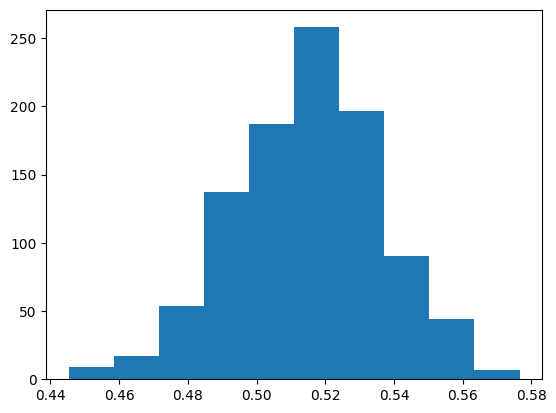

In [118]:
# Confidaence interval
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# configure bootstrap
n_iterations = 1000
n_size = int(len(y_test) * 0.5)
# run bootstrap
stats = list()

for i in range(n_iterations):
    # prepare train and test sets
    test = resample(y_test, n_samples=n_size)
    # calculate accuracy
    accuracy = accuracy_score(test[target], test["predicted"])
    stats.append(accuracy)

# plot scores
plt.hist(stats)
plt.show()

In [119]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test[target], y_test["predicted"]))
# print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.47      0.44      0.46       461
           1       0.55      0.58      0.56       546

    accuracy                           0.52      1007
   macro avg       0.51      0.51      0.51      1007
weighted avg       0.51      0.52      0.51      1007



In [120]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[target], y_test["predicted"])


array([[205, 256],
       [232, 314]], dtype=int64)

In [121]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# indices
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print(f"{f + 1}. feature {x_train.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature close_rolling_exp_mean_14 (0.009573663584887981)
2. feature close_bollinger_lower_14 (0.0071613984182477)
3. feature high_bollinger_lower_14 (0.006794298533350229)
4. feature close_bollinger_lower_7 (0.00622015492990613)
5. feature high_bollinger_upper_7 (0.006172428838908672)
6. feature close_lag_16 (0.005907529499381781)
7. feature close_lag_21 (0.005354975815862417)
8. feature high_lag_26 (0.00534101203083992)
9. feature low_lag_7 (0.005105593707412481)
10. feature high_lag_10 (0.005100221373140812)
11. feature high_bollinger_lower_7 (0.0050500198267400265)
12. feature open_lag_24 (0.004898459184914827)
13. feature close_lag_22 (0.004835602827370167)
14. feature high_lag_7 (0.0048035248182713985)
15. feature close_rolling_mean_14 (0.004777497611939907)
16. feature open_lag_3 (0.0047641322016716)
17. feature high_lag_28 (0.0047445148229599)
18. feature low_lag_19 (0.004740889184176922)
19. feature low_lag_5 (0.004715430084615946)
20. feature long_ema_200 (

In [122]:
# Save predicted values
y_test.sort_index().to_parquet("../data/predicted.parquet")